## Task 2


In [7]:
import numpy as np
import pandas as pd
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

min_T=0.0000001

def annealing(func,x,T):
    '''
    func - h function
    x - argument 
    T - temperature
    return p(x)
    '''
    return np.power(np.e,(-func(x)/T))

def sa_algorithm(func, g_x, n, max_iter=5000, an_rate=0.99):
    '''
    func - function to optimize
    g_x - proposed distribution
    max_iter - maximum number of iterations
    an_rate - annealing rate
    '''
    history =[]
    
    x_t = list(range(0,n)) # permutation
    global_sol = copy.deepcopy(x_t)
    T = 2000
    for iter in range(max_iter):
        x = g_x(x_t)
        alpha = annealing(func,x,T)/annealing(func,x_t,T)
        if (np.random.random()<=alpha): 
            x_t = copy.deepcopy(x)
        if func(global_sol)>=func(x_t): # update global min
            global_sol =copy.deepcopy(x_t)
        
        history.append(copy.deepcopy(x_t))
        T = T*an_rate
        if T < min_T:
            break
    
    return global_sol, history

# Functions

In [13]:
import math

def distance(lon1,lat1,lon2,lat2):
    '''
    distance between two points on earth given their longitute and latitude
    https://www.movable-type.co.uk/scripts/latlong.html
    '''
    lon1_r = math.radians(lon1) 
    lat1_r = math.radians(lat1) 
    lon2_r = math.radians(lon2) 
    lat2_r = math.radians(lat2) 
    R = 6371e3
    dlon = (lon2_r-lon1_r)
    dlat = (lat2_r-lat1_r)
    a = math.sin(dlat/2)*math.sin(dlat/2)+math.cos(lat1_r)*math.cos(lat2_r)*(math.sin(dlon/2)*(math.sin(dlon/2)))
    c = 2*math.atan2(math.sqrt(a),math.sqrt(1-a))
    return R*c

def loss_func(path):
    '''
    Function that will be optimized
    '''
    answer = 0
    for ind_n in range(len(path)-1):
        answer+= distance_matrix[path[ind_n]][path[ind_n+1]]
    answer+= distance_matrix[0][-1]
    return answer/1000 # scale in order to not get zero

def permutate_two_elements(old):
    '''
    It is g(x)
    '''
    x = copy.deepcopy(old)
    n = len(x)
    to_swap = np.random.choice(range(0, n), 2)
    a = x[to_swap[0]]
    x[to_swap[0]] = x[to_swap[1]]
    x[to_swap[1]] = a
    return x

def display_loss(history):
    losses = list(map(lambda x:loss_func(x),history))
    plt.plot(losses)
    plt.show()
    

# Load data

In [3]:
import re
import json
N = 30 # number of the most popular cities
df = pd.read_csv("city.csv") 

df['population'] = df.population.apply(lambda x: int(re.sub("[^0-9]", "",x))) # remove redundant symbols
df['population'] = pd.to_numeric(df['population'])
df = df.sort_values(by='population', ascending=False)

cities = list(df.address[:N])
population = list(df.population[:N])
lat = list(df.geo_lat[:N])
lon = list(df.geo_lon[:N])

with open('russia.json') as json_file:
    border_data = json.load(json_file)
    
borders =  border_data[0]["geojson"]['coordinates']

distance_matrix = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        distance_matrix[i][j] = distance(lon[i],lat[i],lon[j],lat[j]);

# Transformations

In [101]:
import utm
import pyproj as proj

# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj(init='epsg:27700') # use a locally appropriate projected CRS

# cast geographic coordinate pair to the projected system

coords = np.array([ proj.transform(crs_wgs, crs_bng,lon[i],lat[i]) for i in range(len(lon))])
boorders_latlon = list(map(lambda x: x[0], borders))
boorder_coords = []

for c in boorders_latlon:
    print(len(c))
    arr = []
    for t in range(0,len(c),max(1,int(len(c)/1000))): #skip sime points because it is too slow
        arr.append(proj.transform(crs_wgs, crs_bng,c[t][0],c[t][1]))
    boorder_coords.append(arr)
        


22
528
116
27
7208
94036
21
80
479
130
79
70
104
125
37
139
82
104
104
17
280
17
407
67
94
48
45
129
116
93


C:\Users\arsee\Anaconda3\envs\keras_env\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


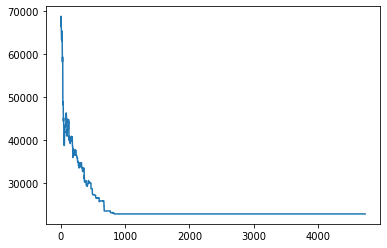

In [18]:
best, history = sa_algorithm(loss_func, permutate_two_elements,N ,an_rate=0.995)

display_loss(history)


# Drawings


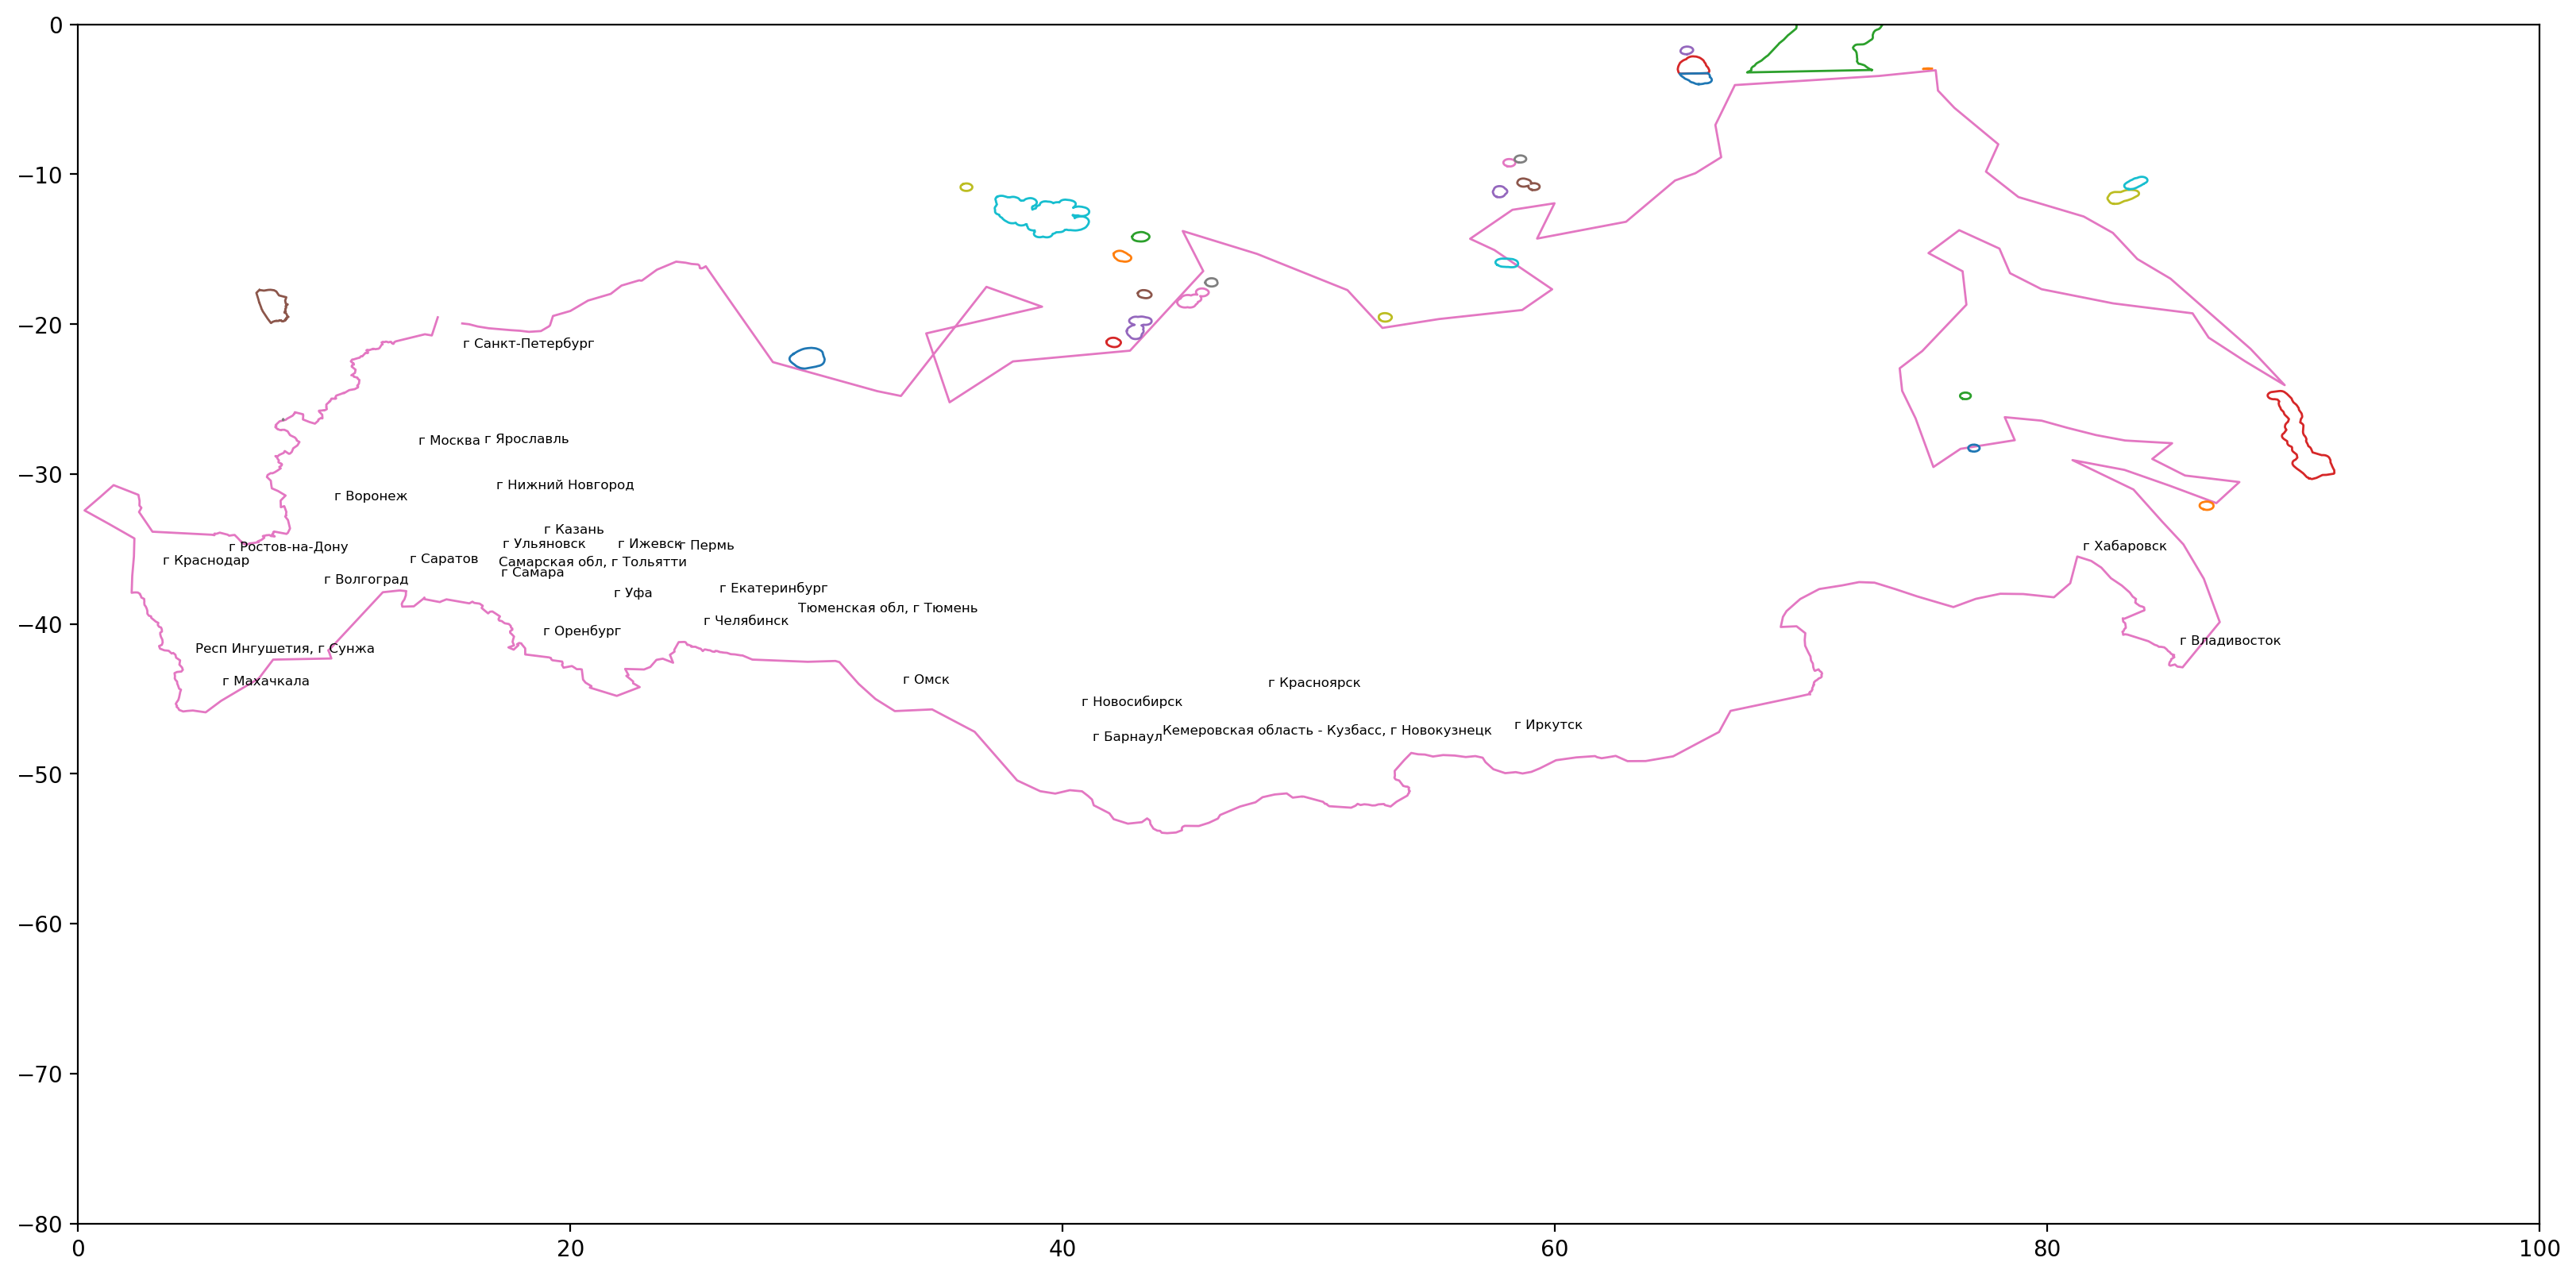

In [136]:

scale_factor = 100000 # scale all coordinated by this factor

fig = plt.figure(num=None, figsize=(20, 10), dpi=200, facecolor='w', edgecolor='k')

ax = plt.axes(xlim=(0, 100), ylim=(-80, 0))
line, = ax.plot([], [],lw=1)
loss = ax.text(0.02, 0.95, '',fontsize=10,transform=ax.transAxes)
city_names = [ax.text(0.02, 0.95, '',fontsize=6) for i in range(N)]
border_oulines = [ ax.plot([], [],lw=1) for i in range(len(boorder_coords))]

def init():
    '''
    Function that inits loss display,lines, city labels, and country borders
    '''
    line.set_data([], [], )
    loss.set_text('')
    for i in range(N):
        city_names[i].set_text(cities[i])   
        city_names[i].set_x(coords[i][1]/scale_factor)
        city_names[i].set_y(-coords[i][0]/scale_factor)
    for i in range(len(border_oulines)):
        x = [j[1]/scale_factor for j in boorder_coords[i]]
        y = [-j[0]/scale_factor for j in boorder_coords[i]]
        border_oulines[i][0].set_data(x, y)
        
    return line, loss, 

def animate(i):
    '''
    Function that animates path
    '''
    # draw path 
    x = [i[1]/scale_factor for i in coords[history[i]]]
    x.append(coords[history[i]][0][1]/scale_factor) # close path
    y = [-i[0]/scale_factor for i in coords[history[i]]]
    y.append(-coords[history[i]][0][0]/scale_factor) # close path
   
    line.set_data(x, y)
    loss.set_text(str(loss_func(history[i])))
    return line, loss

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(history), interval=20, blit=True)

plt.show()

In [137]:
plt.rcParams['animation.ffmpeg_path'] ='C:\\Users\\arsee\\ffmpeg\\bin\\ffmpeg.exe'
FFwriter=animation.FFMpegWriter(fps=20, extra_args=['-vcodec', 'libx264'])
anim.save('plswork.mp4', writer=FFwriter)

In [138]:
print(loss_func(best))

29833.199743679437
